Stock 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Drop the 'Profession' column as it's not relevant
data.drop('Profession', axis=1, inplace=True)

# Define appliance columns and target variable
appliance_columns = ['Rooms', 'Fans', 'Lights', 'Freezes', 'Microwave Oven', 'Geyser', 'AC', 'Washing Machine', 'TV', 'PC', 'Induction Stove']
target_variable = 'pre_23_dec_unit'

# Impute missing values with zero for appliance counts
data[appliance_columns] = data[appliance_columns].fillna(0)

# Convert all columns to numeric, coercing any invalid values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Neighboring Average for Monthly Units
unit_columns = [
    'post_21_july_unit', 'post_21_august_unit', 'post_21_sep_unit', 'post_21_oct_unit',
    'post_21_nov_unit', 'post_21_dec_unit', 'post_22_jan_unit', 'post_22_feb_unit',
    'pre_23_jan_unit', 'pre_23_feb_unit', 'pre_23_mar_unit',
    'pre_23_apr_unit', 'pre_23_may_unit', 'pre_23_june_unit', 'pre_23_jul_unit',
    'pre_23_aug_unit', 'pre_23_sep_unit', 'pre_23_oct_unit', 'pre_23_nov_unit'
]
for i in range(1, len(unit_columns)-1):
    data[unit_columns[i]] = data[unit_columns[i]].fillna(
        (data[unit_columns[i-1]] + data[unit_columns[i+1]]) / 2
    )

# Normalize the dataset
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

selected_features = appliance_columns + unit_columns
data_scaled = feature_scaler.fit_transform(data[selected_features])
target_scaled = target_scaler.fit_transform(data[[target_variable]])

# Combine scaled features and target
data_scaled = np.hstack((data_scaled, target_scaled))

# Creating sequences with a length of 30
seq_length = 30
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, seq_length)

# Define the LSTM model with the best hyperparameters
def create_model():
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, X.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return model

# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    
    y_val_pred = model.predict(X_val)
    y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    
    mse = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    mae = mean_absolute_error(y_val_rescaled, y_val_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Calculate average metrics
average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

print(f'Average MSE across {k} folds: {average_mse}')
print(f'Average MAE across {k} folds: {average_mae}')
print(f'Average RMSE across {k} folds: {average_rmse}')
print(f'Average R-squared across {k} folds: {average_r2}')


ValueError: could not convert string to float: '`'

Use optimized one 

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Drop the 'Meter No' column as it's not relevant
# data.drop('Meter No', axis=1, inplace=True)

# Define appliance columns and target variable
appliance_columns = ['Rooms', 'Fans', 'Lights', 'Freezes', 'Microwave Oven', 'Geyser', 'AC', 'Washing Machine', 'TV', 'PC', 'Induction Stove']
target_variable = 'pre_23_dec_unit'

# Impute missing values with zero for appliance counts
data[appliance_columns] = data[appliance_columns].fillna(0)

# Neighboring Average for Monthly Units
unit_columns = [
    'post_21_july_unit', 'post_21_august_unit', 'post_21_sep_unit', 'post_21_oct_unit',
    'post_21_nov_unit', 'post_21_dec_unit', 'post_22_jan_unit', 'post_22_feb_unit',
    'pre_23_jan_unit', 'pre_23_feb_unit', 'pre_23_mar_unit',
    'pre_23_apr_unit', 'pre_23_may_unit', 'pre_23_june_unit', 'pre_23_jul_unit',
    'pre_23_aug_unit', 'pre_23_sep_unit', 'pre_23_oct_unit', 'pre_23_nov_unit'
]
for i in range(1, len(unit_columns)-1):
    data[unit_columns[i]] = data[unit_columns[i]].fillna(
        (data[unit_columns[i-1]] + data[unit_columns[i+1]]) / 2
    )

# Normalize the dataset
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

selected_features = appliance_columns + unit_columns
data_scaled = feature_scaler.fit_transform(data[selected_features])
target_scaled = target_scaler.fit_transform(data[[target_variable]])

# Combine scaled features and target
data_scaled = np.hstack((data_scaled, target_scaled))

# Creating sequences with a length of 30
seq_length = 30
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, seq_length)

# Define the LSTM model with the best parameters
def create_model(neurons=100, dropout_rate=0.3, optimizer='rmsprop'):
    model = Sequential()
    model.add(Input(shape=(seq_length, X.shape[2])))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model(neurons=100, dropout_rate=0.3, optimizer='rmsprop')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    
    y_val_pred = model.predict(X_val)
    y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    
    mse = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    mae = mean_absolute_error(y_val_rescaled, y_val_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Calculate average metrics
average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

print(f'Average MSE across {k} folds: {average_mse}')
print(f'Average MAE across {k} folds: {average_mae}')
print(f'Average RMSE across {k} folds: {average_rmse}')
print(f'Average R-squared across {k} folds: {average_r2}')

# Visualization of the metrics
metrics = ['MSE', 'MAE', 'RMSE', 'R-squared']
scores = [average_mse, average_mae, average_rmse, average_r2]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'red', 'purple'])
plt.title('Average Performance Metrics Across K-Folds')
plt.ylabel('Score')
plt.savefig('actual_vs_predicted_KeRE.png')
plt.show()


KeyError: "['Meter No'] not found in axis"

Figure Updated

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


C:\Users\Shadow\AppData\Local\Temp\ipykernel_26288\874044775.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([mse_scores, mae_scores, rmse_scores, r2_scores], labels=['MSE', 'MAE', 'RMSE', 'R2'])


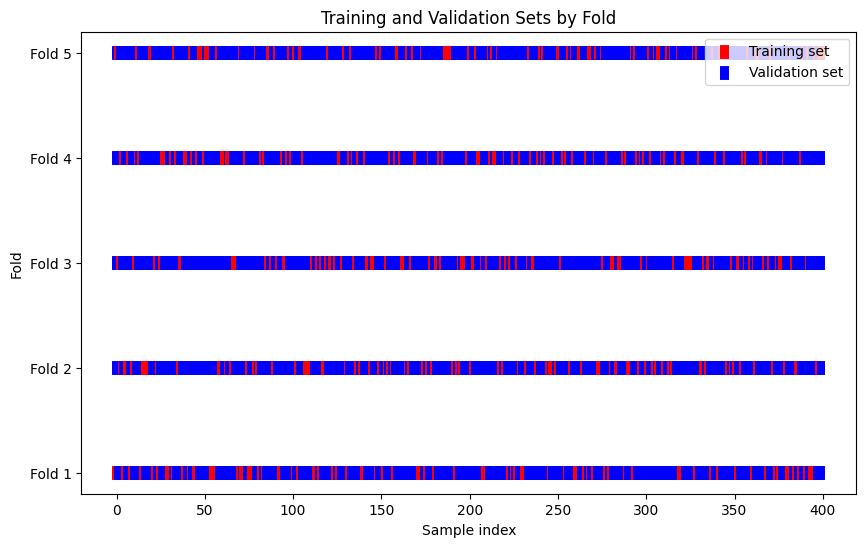

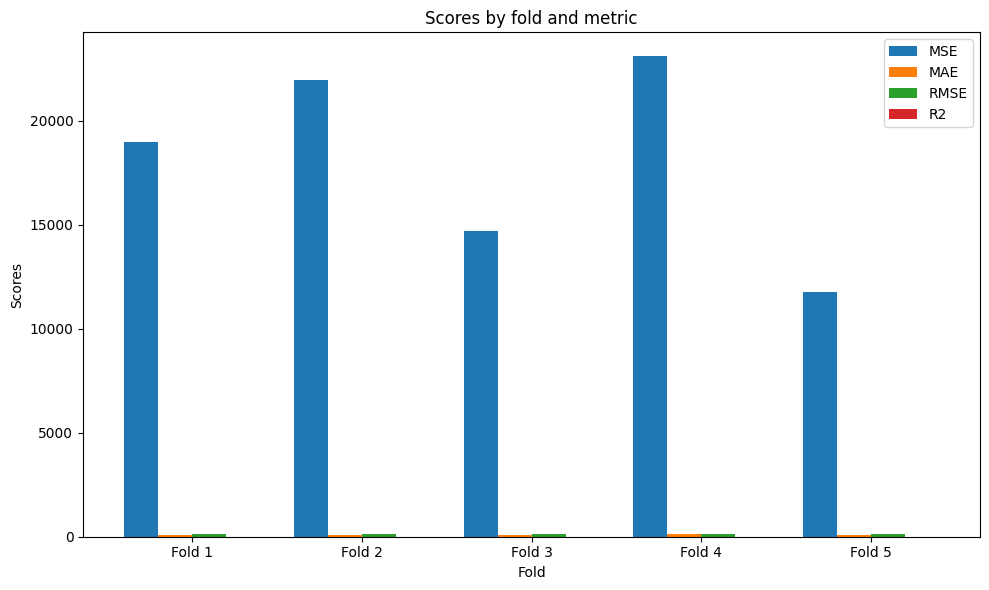

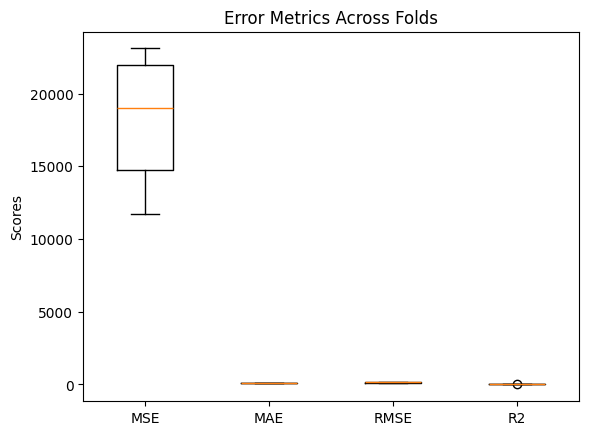

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'C:\\Users\\Shadow\\Desktop\\GIT_PE\\survey_data\\survey_data.csv'
data = pd.read_csv(file_path)

# Drop irrelevant columns
data.drop('Meter No', axis=1, inplace=True)

# Define appliance columns and target variable
appliance_columns = ['Rooms', 'Fans', 'Lights', 'Freezes', 'Microwave Oven', 'Geyser', 'AC', 'Washing Machine', 'TV', 'PC', 'Induction Stove']
target_variable = 'pre_23_dec_unit'

# Impute missing values
data[appliance_columns] = data[appliance_columns].fillna(0)
unit_columns = [
    'post_21_july_unit', 'post_21_august_unit', 'post_21_sep_unit', 'post_21_oct_unit',
    'post_21_nov_unit', 'post_21_dec_unit', 'post_22_jan_unit', 'post_22_feb_unit',
    'pre_23_jan_unit', 'pre_23_feb_unit', 'pre_23_mar_unit',
    'pre_23_apr_unit', 'pre_23_may_unit', 'pre_23_june_unit', 'pre_23_jul_unit',
    'pre_23_aug_unit', 'pre_23_sep_unit', 'pre_23_oct_unit', 'pre_23_nov_unit'
]
for i in range(1, len(unit_columns)-1):
    data[unit_columns[i]] = data[unit_columns[i]].fillna(
        (data[unit_columns[i-1]] + data[unit_columns[i+1]]) / 2
    )

# Normalize the dataset
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))
selected_features = appliance_columns + unit_columns
data_scaled = feature_scaler.fit_transform(data[selected_features])
target_scaled = target_scaler.fit_transform(data[[target_variable]])
data_scaled = np.hstack((data_scaled, target_scaled))

# Creating sequences
seq_length = 30
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)
X, y = create_sequences(data_scaled, seq_length)

# Define the LSTM model
def create_model(neurons=100, dropout_rate=0.3, optimizer='rmsprop'):
    model = Sequential([
        Input(shape=(seq_length, X.shape[2])),
        LSTM(neurons, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(neurons),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    y_val_pred = model.predict(X_val)
    y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    mse = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    mae = mean_absolute_error(y_val_rescaled, y_val_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Visualization of the K-Fold Cross Validation Splits
def plot_cv_indices(cv, X, ax, lw=10):
    """Plot each cross-validation fold"""
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        indices = np.array([None] * len(X))
        indices[test_index] = "Validation"
        indices[train_index] = "Training"
        ax.scatter(range(len(indices)), [i + 0.5] * len(indices),
                   c=np.where(indices == "Validation", 'r', 'b'), marker='_', lw=lw)
    ax.set(yticks=np.arange(cv.n_splits) + 0.5, yticklabels=[f"Fold {i+1}" for i in range(cv.n_splits)],
           xlabel='Sample index', ylabel='Fold', title='Training and Validation Sets by Fold')
    ax.legend(['Training set', 'Validation set'], loc='best')

# Plotting and saving figures
X_dummy = np.arange(len(data_scaled))  # Dummy data for visualization
fig, ax = plt.subplots(figsize=(10, 6))
plot_cv_indices(kf, X_dummy, ax)
plt.savefig('KFold_Splits.png')

# Grouped Bar Chart for Error Metrics
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(k)
bar_width = 0.2

rects1 = ax.bar(index, mse_scores, bar_width, label='MSE')
rects2 = ax.bar(index + bar_width, mae_scores, bar_width, label='MAE')
rects3 = ax.bar(index + 2 * bar_width, rmse_scores, bar_width, label='RMSE')
rects4 = ax.bar(index + 3 * bar_width, r2_scores, bar_width, label='R2')

ax.set_xlabel('Fold')
ax.set_ylabel('Scores')
ax.set_title('Scores by fold and metric')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels([f"Fold {i+1}" for i in range(k)])
ax.legend()

plt.tight_layout()
plt.savefig('Error_Metrics_Bar_Chart.png')

# Boxplot for Error Metrics
fig, ax = plt.subplots()
ax.boxplot([mse_scores, mae_scores, rmse_scores, r2_scores], labels=['MSE', 'MAE', 'RMSE', 'R2'])
ax.set_title('Error Metrics Across Folds')
ax.set_ylabel('Scores')
plt.savefig('Error_Metrics_Boxplot.png')

plt.show()
